# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. Метрика MAE должна быть меньше 7. В вашем распоряжении набор фотографий людей с указанием возраста.

## Описание данных

Данные взяты с сайта *ChaLearn Looking at People*. 

Они находятся в папке `/datasets/faces/`. В нашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

## Подключение библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

## Предварительный обзор данных

In [3]:
# Предварительный обзор данных
def data_overview(reviewed_dataframe):
    print('=' * 125)
    print('Общая информация о датафрейме:\n')
    print(reviewed_dataframe.info())
    print('*' * 125)
    print('Датафрейм:\n')
    print(reviewed_dataframe.head())
    print('*' * 125)
    print('Размер датафрейма:\n')
    print(reviewed_dataframe.shape)

In [4]:
data_overview(data)

Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
*****************************************************************************************************************************
Датафрейм:

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
*****************************************************************************************************************************
Размер датафрейма:

(7591, 2)


Датасет состоит из 7591 фотографий покупателей. Пропуски в данных отсутствуют. Типы данных соответствуют содержащимся в столбцах значениям.

## Исследовательский анализ данных

### График распределения возраста людей

Построим график распределения возраста людей.

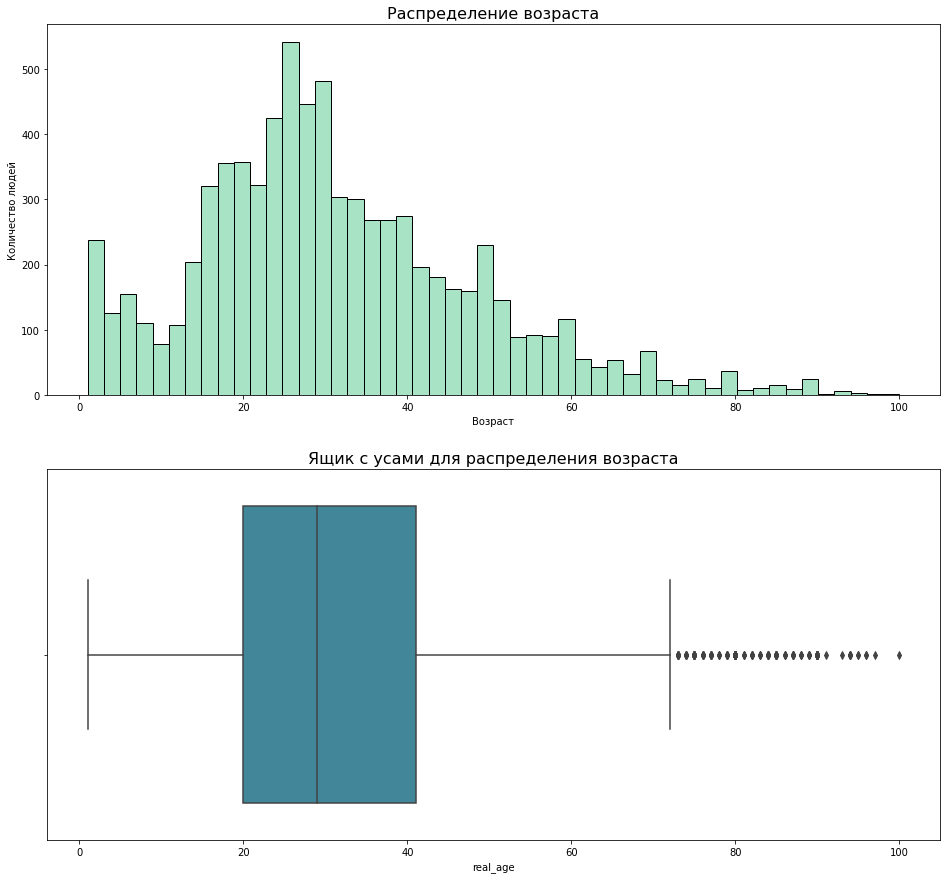

In [6]:
# Настройка цветовой палитры
palette = sns.color_palette("mako", as_cmap=False)

fig, axs = plt.subplots(2, 1, figsize=(16, 15))

# Гистограмма распределения возраста
color_hist = palette[5]
sns.histplot(data=data, x='real_age', color=color_hist, bins=50, ax=axs[0])
axs[0].set_title('Распределение возраста', fontsize=16)
axs[0].set_xlabel('Возраст')
axs[0].set_ylabel('Количество людей')

# Ящик с усами для распределения возраста
color_box = palette[3]
sns.boxplot(x='real_age', data=data, color=color_box, ax=axs[1])
axs[1].set_title('Ящик с усами для распределения возраста', fontsize=16)

plt.show()

In [7]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Распределение возраста людей близко к равномерному. Однако наблюдается положительная ассиметрия - небольшой хвост и сдвиг вправо, обусловленный наличием необычно высоких значений. Это покупатели с возрастом более 75 лет, то есть люди старческого возраста и долгожители. Ассиметрия повлекла за собой сдвиг среднего значения в сторону выбросов - оно составляет 31 год, что больше медианного значения, равного 29 годам. Возраст большинства лежит в диапазоне от 1 до 60 лет. Также можно отметить бимодальность распределения, что может говорить о разных источниках, возможно. Плюс наблюдаются некоторые отдельные пики - это, возможно, результаты округления.

### Устройство датасета

In [8]:
datagen = ImageDataGenerator(rescale=1./255) 

In [9]:
# Выгрузим изображения из папки
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    # папка, в которой хранится датасет
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    # к какому размеру приводить изображения
    target_size=(150, 150), 
    # размер батча
    batch_size=16,
    # в каком виде выдавать метки классов
    class_mode='raw',
    # фиксируем генератор случайных чисел (от англ. random seed)
    seed=12345) 

Found 7591 validated image filenames.


In [10]:
# Получим набор 16-ти признаков и их таргета
features, target = next(datagen_flow)

In [11]:
# Посмотрим значения параметров тензора
features.shape

(16, 150, 150, 3)

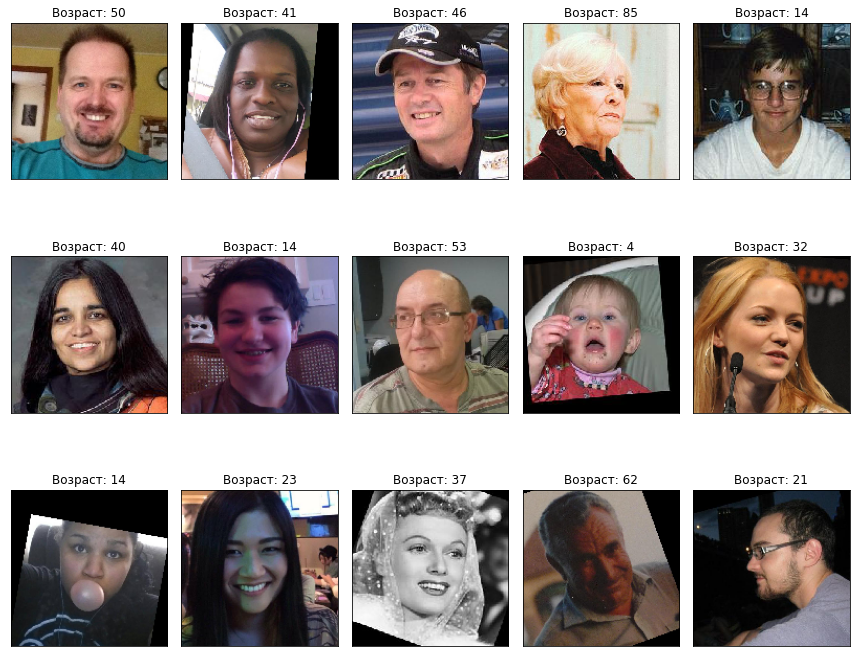

In [12]:
# Выведем 15 фотографий на экран 
fig = plt.figure(figsize=(12, 12))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы рассмотрели батч из 16 изображений размером 150x150 с тремя цветовыми каналами. Датасет содержит как цветные фотографии людей, так и черно-белые.

## Обучение модели

Обучим модель в GPU-тренажёре. В качестве функции потерь используем MAE.

In [13]:
def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        # папка, в которой хранится датасет
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        # к какому размеру приводить изображения
        target_size=(150, 150),
        # размер батча
        batch_size=16,
        # в каком виде выдавать метки классов
        subset='training',
        class_mode='raw',
        # фиксируем генератор случайных чисел (от англ. random seed)
        seed=12345)

    return train_datagen_flow


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        # папка, в которой хранится датасет
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        # к какому размеру приводить изображения
        target_size=(150, 150),
        # размер батча
        batch_size=16,
        # в каком виде выдавать метки классов
        subset='validation',
        class_mode='raw',
        # фиксируем генератор случайных чисел (от англ. random seed)
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True
              )
    return model

Train for 356 steps, validate for 119 steps

Epoch 1/5
2024-11-03 08:26:06.733454: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-11-03 08:26:07.197336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 61s - loss: 209.8099 - mae: 10.6087 - val_loss: 457.1822 - val_mae: 16.2955

Epoch 2/5
356/356 - 47s - loss: 68.5142 - mae: 6.3370 - val_loss: 167.8486 - val_mae: 9.6894

Epoch 3/5
356/356 - 47s - loss: 38.6843 - mae: 4.8217 - val_loss: 79.3338 - val_mae: 6.7098

Epoch 4/5
356/356 - 47s - loss: 24.8839 - mae: 3.8160 - val_loss: 104.2754 - val_mae: 8.1251

Epoch 5/5
356/356 - 47s - loss: 15.2774 - mae: 3.0129 - val_loss: 77.2708 - val_mae: 6.4783

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

**119/119 - 12s - loss: 77.2708 - mae: 6.4783**

## Анализ обученной модели

Для обучения модели была использована архитектура ResNet. Снижение ошибок на тренировочной и тестовой выборках указывает на успешное обучение модели. Однако колебания на тестовой выборке могут указывать на переобучение, особенно в последних эпохах, когда значение функции потерь снова увеличивается.
Конечный MAE около 6.5, то есть меньше 7, что соответсвует условиям проекта.
Для улучшения результатов модели, основанной на архитектуре ResNet, можно применить регуляризацию, увеличить объем тренировочных данных или же рассмотреть использование более глубокой архитектуры, например, , ResNet101.